### Assignment 4 - Hidden Markov Models

#### Beltrán Liniers  nº57646

#### Luís Santos nº57470

#### Problem 2)

In [1]:
import numpy as np
from hmmlearn import hmm
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

No presente assignment foi requerido que se treinasse um Hidden Markov Model (HMM) para prever os estados do problema do Casino Desonesto. No dado problema, pode-se identificar dois estados, o fair dice (F) e o loaded dice (L). A probabilidade de transitar de F para L é de 0.05. Assim, a probabilidade de se manter no estado F é de 0.95. Adicionalmente, a probabilidade de transitar do estado L para F é de 0.1. Pelo que a probabilidade de se manter no estado L é de 0.90. 

Assim, as probabilidades iniciais de estado são dadas por  $\pi_{1}=\frac{0.1}{0.1+0.05}$ e $\pi_{2}=\frac{0.05}{0.1+0.05}$ 

Adicionalmente, a matriz de emissão é constituída por: $B=\begin{bmatrix} \frac{1}{6} & \frac{1}{6} & \frac{1}{6} & \frac{1}{6} & \frac{1}{6} & \frac{1}{6} \\ \frac{1}{10} & \frac{1}{10} & \frac{1}{10} & \frac{1}{10} & \frac{1}{10} & \frac{5}{10} \end{bmatrix}$

Por fim a matriz de transmissão é definida por : $A=\begin{bmatrix} 0.95 & 0.05\\ 0.1 & 0.9 \end{bmatrix}$

##### a)

Na alínea a), como foi pedido para assumir todos os parâmetros como conhecidos o treino do modelo não foi efetuado. Assim apenas se realizou a parte do decode, para prever os estados sequenciais com base o test set de 10 pontos.

In [2]:
modelMulti = hmm.MultinomialHMM(n_components = 2)
prob_trans_1_to_1 = 0.95
prob_trans_1_to_2 = 0.05
prob_trans_2_to_2 = 0.90
prob_trans_2_to_1 = 0.1
pi_1 = prob_trans_2_to_1/(prob_trans_1_to_2 + prob_trans_2_to_1)
pi_2 = prob_trans_1_to_2/(prob_trans_1_to_2 + prob_trans_2_to_1)

In [3]:
modelMulti.startprob_ = np.array([pi_1,pi_2])
modelMulti.transmat_ = np.array([[0.95,0.05],
                                [0.1,0.9]])
modelMulti.emissionprob_ = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],
                               [1/10,1/10,1/10,1/10,1/10,5/10]])

In [4]:
X = np.array([[6],[6],[4],[1],[5],[3],[2],[1],[6],[1],[6],[2],[1],[1],[5],[2],[3],[4],[6],[5],[3],[2],[1],
     [4],[3],[5],[6],[6],[3],[4],[2],[6],[1],[6],[5],[5],[2],[3],[4],[2],[3],[2],[3],[1],[5],
     [1],[4],[2],[4],[6],[4],[1],[5],[6],[6],[6],[3],[2],[4],[6]])-1
L = 1
F = 0
States = [L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,F,F,F,F,F,L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,F,F,F,F,F,
          F,F,F,F,F,F,F,F,F,F,F,F,L,L,L,L,L,L,L,L]

In [5]:
X_train= X[:-10]
X_test = X[50:]

In [6]:
Z2= modelMulti.decode(X_test)
print("Predicted States: ", Z2[1])
print("Log likelihood:",modelMulti.score(X_test))

Predicted States:  [1 1 1 1 1 1 1 1 1 1]
Log likelihood: -16.98461390418157


Para os últimos 10 pontos o modelo previu sempre o estado 1, ou seja, o estado L. Com um score próximo a (-17).

Como método de avaliação do modelo foi usado o score, que é definido como calcula o somatório dos logaritmos das probabilidades de $P(X_{i}|X_{i-1})$, ou seja, a probabilidade do estado atual dado o estado anterior. É de esperar que este resultado seja negativo, já que se trata de calcular logaritmos de probabilidades. Num cenário perfeito, em que os estados previstos são iguais aos reais, o resultado do score seria 0, o que seria indicativo de um bom modelo.

##### b)

Na alínea b) a matriz de transmissão passa a ser desconhecida, e como tal as probabilidades de estados iniciais, também passam a ser desconhecidas. Assim, foi necessário treinar o modelo para que este aprendesse estes parâmetros. Contudo a matriz de emissão continuou a ser um parâmetro conhecido. 

In [8]:
model_b = hmm.MultinomialHMM(n_components=2)
model_b.emissionprob_ = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],
                               [1/10,1/10,1/10,1/10,1/10,5/10]])
model_b.fit(X_train)
Z3 = model_b.predict(X_test)
print("Predicted States: ", Z3)
print("Log likelihood:",model_b .score(X_test))

Predicted States:  [1 1 0 1 1 1 1 0 0 1]
Log likelihood: -24.76124971053921


Os resultados obtidos foram piores em relação aos da alínea a), onde o score desceu para aproximadamente -0.25.

#### c)

Na alínea c) passou a ser utilizado outro dataset do Casino Desonesto, com um maior número de instâncias. 

##### i)

Na primeira parte do c, será treinado um modelo em que ambas as matrizes, transmissão e emissão, são desconhecidas, mas os estados continuam a ser conhecidos.
A continuação definem-se várias funções que ajudam a automatização dos testes. 

In [11]:
# Encode dos estados
def encode_states(States):
    le = LabelEncoder()
    return le.fit_transform(States)

In [12]:
# Função para retirar uma amostra aleatória do dataset
def get_sample(X,States,sample_size):
    sample = random.sample(range(0,len(X)),sample_size)
    return X[sample], States[sample]

In [13]:
# Função para o treinamento dos modelos
def train_test_model(n_states,X_train,X_test,States):
    model = hmm.MultinomialHMM(n_components=n_states)
    model.fit(X_train)
    states_preds = model.predict(X_test)
    log_prob = model.score(X_test)
    print("Log probability is: ", log_prob)
    return {"score":log_prob}

In [14]:
# Função para o desenho de gráficos e comparação de modelos. No eixo X será representado o score e no Y o número de estados
def plot_metric(scores_100,scores_1000,metric):
    sns.scatterplot(data=pd.DataFrame(scores_100),x=metric,y='n_states')
    sns.scatterplot(data=pd.DataFrame(scores_1000),x=metric,y='n_states')
    plt.title("Comparison of {} between models trained with 100 and 1000 data points".format(metric))
    plt.legend(['HMM_100','HMM_1000'])

In [16]:
# Importamos os ficheros rolls e dice
X = pd.read_csv('rolls.txt').values
States = encode_states(pd.read_csv('dice.txt').values.flatten())

Definiram-se 2 training sets, um composto por 100 instâncias e outro composto por 1000. O test set é composto por 30 instâncias.

In [17]:
X_sample_100, States_sample_100 = get_sample(X,States,100)
X_sample_1000, States_sample_1000 = get_sample(X,States,1000)
X_sample_test,States_sample_test = get_sample(X,States,30)

O treino dos modelos com 100 e 1000 observações respetivamente. Foram definidos dois estados.

O modelo com 100 exemplos obteve um melhor score, embora a diferença não seja muito grande

In [19]:
print("With 100 Data points")
score_100 = train_test_model(2,X_sample_100,X_sample_test,States_sample_100)
print("With 1000 Data points")
score_1000 = train_test_model(2,X_sample_1000,X_sample_test,States_sample_1000)

With 100 Data points
Log probability is:  -48.96455463455435
With 1000 Data points
Log probability is:  -50.621592468401765


##### ii)

Na segunda parte do exercício c), vai se treinar um modelo em que todos os parâmetros são desconhecidos, inclusivamente o número de estados. Para isso vai-se treinar e testar diferentes modelos com diferentes números de estados, de 1 a 4. No processo será registado a probabilidade logarítmica obtida para cada modelo treinado, com 100 e 1000 instâncias.

In [68]:
scores_100 = []
scores_1000 = []
for i in range(1,5):
    print("Number of States: ", i)
    print("With 100 Data points")
    score = train_test_model(i,X_sample_100,X_sample_test,States_sample_test)
    score['n_states'] = i
    scores_100.append(score)
    print("With 1000 Data points")
    score = train_test_model(i,X_sample_1000,X_sample_test,States_sample_test)
    score['n_states'] = i
    scores_1000.append(score)

Number of States:  1
With 100 Data points
Log probability is:  -49.783760023167844
With 1000 Data points
Log probability is:  -50.62241539107734
Number of States:  2
With 100 Data points
Log probability is:  -49.424986243297795
With 1000 Data points
Log probability is:  -49.80184835664711
Number of States:  3
With 100 Data points
Log probability is:  -50.99270120242732
With 1000 Data points
Log probability is:  -50.38497662763659
Number of States:  4
With 100 Data points
Log probability is:  -52.97610047274008
With 1000 Data points
Log probability is:  -50.17796032082033


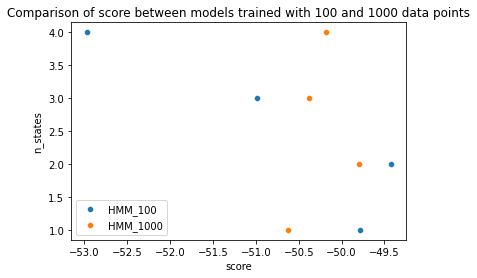

In [69]:
plot_metric(scores_100,scores_1000,'score')

Pode-se ver no gráfico os modelos com dois estados são os que presentam um maior score, pelo que são os que mais se ajustam aos dados reais. Não entanto estes resultados distam muito de zero pelo que consideramos que o modelo poderia ser melhor.